## Simulation of the Alpha Arm with Hydrodynamics

This simulation has only the Alpha arm implemented. The URDF called, ```alphaArmCombo.urdf```, includes the added mass as inertia. 

DON'T SAVE WITH OUTPUTS ENABLED!!!!!!

#### Metadata

Last edited by Hannah Kolano on 1/4/2021

#### Notes

1/3/2021: The default integrator is a Range-Kutta method. It takes the slope (acceleration) at 4 places and takes a weighted average (m1 + 2m2 + 2m3 + m4)/6. That's why it's calling the control function 4 times. 

But! I only want to update the control torques once, not 4 times. Unfortunately, the controller doesn't get passed any information about what stage the integrator is at (OOOOH MAYBE THERE'S A SOLUTION!), so it doesn't know when it can and can't change torque values. 

I also started migrating the controller to a different document... not exactly sure why. It probably shouldn't be organized this way. 

1/4/22: Finished migrating the controller into MyCtlr.jl. All the global values having to do with the controller are contained in the separate file. I like the separation it gives between the simulator and the controller. (Even though I'm using too many global variables. Perhaps I should learn to use cache?)

In [49]:
# Module importing
using RigidBodyDynamics
using LinearAlgebra
using StaticArrays
using MeshCat
using MeshCatMechanisms
using MechanismGeometries
using CoordinateTransformations
using GeometryBasics
using Plots

include("/home/hkolano/onr-dynamics-julia/simulate_with_ext_forces.jl")
include("/home/hkolano/onr-dynamics-julia/MyCtlr.jl")
println("Libraries imported.")


Libraries imported.


In [50]:
# model definition
# ------------------------------------------------------------------------
#                            MODEL DEFINITION
# ------------------------------------------------------------------------
vis = Visualizer()
render(vis)
# Define paths to the URDF files
src_dir = dirname(pathof(RigidBodyDynamics))
urdf_file = joinpath(src_dir, "..", "..", "..", "..", "..", "onr-dynamics-julia", "URDFs", "alphaArmCombo.urdf")
mechanism_alpha = parse_urdf(urdf_file; gravity = [0.0, 0.0, 0.0])

delete!(vis)

# Create visuals of the URDFs
visuals = URDFVisuals(urdf_file)
mvis_alpha = MechanismVisualizer(mechanism_alpha, URDFVisuals(urdf_file), vis[:alpha])

# Name the joints and bodies of the mechanism
base_joint, shoulder_joint, elbow_joint, wrist_joint = joints(mechanism_alpha)
~, shoulder_body, upper_arm_body, elbow_body, wrist_body = bodies(mechanism_alpha)

# Define default frames for each body
shoulder_frame = default_frame(shoulder_body)
upper_arm_frame = default_frame(upper_arm_body)
elbow_frame = default_frame(elbow_body)
wrist_frame = default_frame(wrist_body)
base_frame = root_frame(mechanism_alpha)
# setelement!(mvis_alpha, shoulder_frame) # shows the frame in the visualization

println("URDFs parsed. Visualizers ready. \n")

URDFs parsed. Visualizers ready. 



┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/hkolano/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


In [51]:
# Buoyancy and Gravity Frames
frame_names_cob = ["shoulder_cob", "ua_cob", "elbow_cob", "wrist_cob"]
frame_names_com = ["shoulder_com", "ua_com", "elbow_com", "wrist_com"]
cob_vecs = [SVector{3, Float64}([-0.001, -0.003, .032]), SVector{3, Float64}([0.073, 0.0, -0.002]), SVector{3, Float64}([0.015, -0.012, -.003]), SVector{3, Float64}([0.0, 0.0, -.098])]
com_vecs = [SVector{3, Float64}([0.005, -.001, 0.016]), SVector{3, Float64}([0.073, 0.0, 0.0]), SVector{3, Float64}([0.017, -0.026, -0.002]), SVector{3, Float64}([0.0, 0.003, -.098])]
cob_frames = []
com_frames = []
for i in 1:4
    bod = bodies(mechanism_alpha)[i+1]
    frame_cob = CartesianFrame3D(frame_names_cob[i])
    frame_com = CartesianFrame3D(frame_names_com[i])
    cob_vec = cob_vecs[i]
    com_vec = com_vecs[i]
    cob_transform = Transform3D(frame_cob, default_frame(bod), cob_vec)
    com_transform = Transform3D(frame_com, default_frame(bod), com_vec)
    # setelement!(mvis_alpha, default_frame(bod))
    if !(is_fixed_to_body(bod, frame_cob))
        add_frame!(bod, cob_transform)
        push!(cob_frames, frame_cob)
        # setelement!(mvis_alpha, frame_cob)    # visualizes COB frames in MeshCat
    end
    if !(is_fixed_to_body(bod, frame_com))
        add_frame!(bod, com_transform)
        push!(com_frames, frame_com)
        # setelement!(mvis_alpha, frame_com)    # visualizes COM frames in MeshCat
    end
end

In [52]:
# buoyancy & gravity setup
# ------------------------------------------------------------------------
#                  BUOYANCY & GRAVITY FORCE MAGNITUDES
# ------------------------------------------------------------------------
# f = rho * g * V
# f = 997 (kg/m^3) * 9.81 (m/s^2) * V_in_L *.001 (m^3) = kg m / s^2
# One time setup of buoyancy forces
volumes = [.018, .203, .025, .155] #  shoulder, ua, elbow, wrist,
buoy_force_mags = volumes * 997 * 9.81 * .001
buoy_lin_forces = []
for mag in buoy_force_mags
    lin_force = FreeVector3D(base_frame, [0.0, 0.0, mag])
    push!(buoy_lin_forces, lin_force)
end
print(buoy_lin_forces)

masses = [.194, .429, .115, .333]
grav_forces = masses*9.81
grav_lin_forces = []
for f_g in grav_forces
    lin_force = FreeVector3D(base_frame, [0.0, 0.0, -f_g])
    push!(grav_lin_forces, lin_force)
end

Any[FreeVector3D in "world": [0.0, 0.0, 0.17605026], FreeVector3D in "world": [0.0, 0.0, 1.9854557100000003], FreeVector3D in "world": [0.0, 0.0, 0.24451425000000004], FreeVector3D in "world": [0.0, 0.0, 1.5159883500000002]]

In [53]:
# Hydrodynamics calculator function
# ------------------------------------------------------------------------
#                HYDRODYNAMICS (Grav & Buoy) CALCULATOR
# ------------------------------------------------------------------------
function hydro_calc!(hydro_wrenches::Dict{BodyID, Wrench{Float64}}, t, state_alpha::MechanismState)
    # println("started hydro calc")
    names = ["cob1", "cob2", "cob3", "cob4"]
    # Iterate through buoyancy for each body
    for i in 1:4
        # Get the body
        bod = bodies(mechanism_alpha)[i+1]
        # Get default frame of te body
        body_default_frame = default_frame(bod)
        # Get transform between the defualt frame and the center of buoyancy
        # TODO: don't use fixed_transform because it's bad for computation time
        def_to_cob = fixed_transform(bod, body_default_frame, cob_frames[i])
        def_to_com = fixed_transform(bod, body_default_frame, com_frames[i])
        # Transform buoyancy force vector to the body's default frame (rotation only)
        buoy_force_trans = transform(state_alpha, buoy_lin_forces[i], body_default_frame)
        grav_force_trans = transform(state_alpha, grav_lin_forces[i], body_default_frame)
        # Make the wrench: the buoyancy force through a point, the center of buoyancy.
        buoy_wrench = Wrench(Point3D(body_default_frame, translation(inv(def_to_cob))), buoy_force_trans)
        grav_wrench = Wrench(Point3D(body_default_frame, translation(inv(def_to_com))), grav_force_trans)
        # Add the buoyancy wrench and grav wrench together
        wrench = buoy_wrench + grav_wrench
        # println(wrench)
        # setelement!(mvis_alpha, Point3D(body_default_frame, translation(inv(def_to_cob))), 0.02, "name")
        # Transform the wrench to the root frame and assign it to the body
        hydro_wrenches[BodyID(bod)] = transform(state_alpha, wrench, root_frame(mechanism_alpha))
    end
    # println("Finished hydro calc")
end;


In [54]:
# initial conditions
# ------------------------------------------------------------------------
#                          INITIAL CONDITIONS
# ------------------------------------------------------------------------
# Initialize state of alpha arm
state_alpha = MechanismState(mechanism_alpha)
zero!(state_alpha)
set_configuration!(state_alpha, base_joint, 3.141)
# set_configuration!(state, shoulder_joint, -.27079)
# set_configuration!(state, elbow_joint, 3.1415/2+1.3)
# set_configuration!(state, wrist_joint, 0.5)

# Simulation Parameters
dt = 2.5e-3
t_final = 3

MyCtlr.ctlr_setup(mechanism_alpha, state_alpha, time_step=dt)

4-element SegmentedVector{JointID, Float64, Base.OneTo{JointID}, Vector{Float64}}:
   6.9179088072549e-310
   6.91790880725726e-310
   6.91790880725964e-310
 NaN

In [55]:
# simulation
# ------------------------------------------------------------------------
#                              SIMULATION
# ------------------------------------------------------------------------
ts, qs, vs = simulate_with_ext_forces(state_alpha, t_final, hydro_calc!, MyCtlr.simple_control!; Δt = dt)
# ts, qs, vs = simulate(state_alpha, final_time, simple_control!; Δt = 1e-2)

println("Simulation finished.")
println(length(vs))

Made it to the simulate function!
Simulation finished.
1202


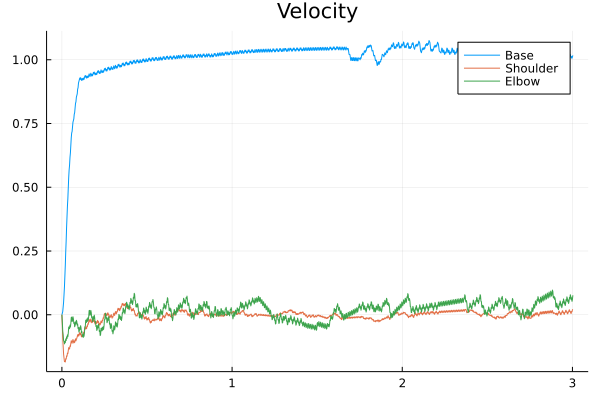

In [56]:
# Plotting
# println("length of times: ", length(times), " length of des_vels: ", length(des_vels), " length of taus: ", length(ctlr_taus))
# println(times)
its = [1:1:length(vs);]
# sim_times = [0:dt:t_final]
# plot(times[begin:2:end], ctlr_taus[begin:2:end], seriestype = :scatter, title="My Scatter Plot")

vs_base = getindex.(vs,1)
vs_shoulder = getindex.(vs,2)
vs_elbow = getindex.(vs, 3)
vs_wrist = getindex.(vs, 4)
# println(vs_base)
plot(ts, vs_base, label="Base", title="Velocity")
plot!(ts, vs_shoulder, label="Shoulder")
plot!(ts, vs_elbow, label="Elbow")
# plot!(ts, vs_wrist, label="Wrist")


# plot(times, ctlr_taus, title="Controller Torques")
# println(length(times))
# println(length(ctlr_taus))


In [57]:
# ------------------------------------------------------------------------
#                             VISUALIZATION
# ------------------------------------------------------------------------
MeshCatMechanisms.animate(mvis_alpha, ts, qs; realtimerate = 1.)
# print(last(qs))

# println("\n done.")